In [1]:
#Partially adopted from Tensorflow/docs/basic_text_classification
#https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

#As well as https://developers.google.com/machine-learning/guides/text-classification/

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np

print(tf.__version__)

import nltk
nltk.download('punkt')
from nltk import word_tokenize
stemmer = nltk.stem.SnowballStemmer('english')

Using TensorFlow backend.


1.11.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#MAPPING SENTENCES TO LIBRARY
import json

#declare trainData as an empty list
testData = []
testLabels = []
    
#temp list for each sentence
tempList = []

#Keeping track of used sentences
used = []

#Keeping track of used requirement statements
security = []
nosecurity = []

#this is the smallest number of unique non-functional requirements of a single class
LIMIT = 270

#library a.k.a. bag of words
with open("Consolidated_data.txt","r") as f, open("libraryStemmed.json", "r") as l:
    data = json.load(l)

    #Go line by line in original data file
    for line in f:
        #find where class begins
        front = line.find("\"class\":\"")
        #find where class ends (where sentence begins)
        end = line.find("\",\"sentence\":\"")
        #substring line based on front and end above
        reqClass = (line[(front+9):end]).lower()

        #sentence
        del tempList[:]
        temp = line.find("\"sentence\":\"")
        sentence = (line[(temp+12):-4]).lower()
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip()
        
        
        if "security" in reqClass and (len(security) < LIMIT):
            if sentence in used:
                continue
            used.append(sentence)
            security.append(sentence)
            testLabels.append(1)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            testData.append(tempList[:])
        elif "security" not in reqClass and (len(nosecurity) < LIMIT):
            if sentence in used:
                continue
            used.append(sentence)
            nosecurity.append(sentence)
            testLabels.append(0)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            testData.append(tempList[:])

In [4]:
#Must all be balanced for valid results.
#Commented out the total number of sentences in the document.
print len(security) #270
print len(nosecurity)

270
270


In [5]:
import csv
import requests

S = requests.Session()
URL = "https://en.wikipedia.org/w/api.php"

def parsePage(title):
    PARAMS = {
    'action': "parse",
    'page': title,
    'prop': 'wikitext',
    'format': "json"
    }
    
    res = S.get(url=URL, params=PARAMS)
    data = res.json()
    wikitext = data['parse']['wikitext']['*']
    lines = wikitext.split('|-')
    entries = []
    b = ",-\":;~!@#$%^&?[]{}<>`1234567890\\*()\'/|="
    for char in b:
        lines[0] = lines[0].replace(char, "")
        
    while lines[0].find("\n") is not (None or -1):
        current = lines[0].find("\n")
        entries.append(lines[0][:current+1])
        lines[0] = lines[0][current+1:]
        
    pageContent = []
    for line in entries:
        index = entries.index(line)
            
        #removing words that do not carry any meaning (longer than 16 chars)
        for key in line.split(" "):
            if len(key) > 16:
                line = line.replace(key, "")
                
        #if line is not empty and wordcount > 20, line will be used for training
        if line != '\n' and (len(line.split(" ")) > 20):
            pageContent.append(line.strip())
        
    train = []
    for line in pageContent:
        for item in line.split("."):
            if(len(item.split(" ")) > 10): # and item[0].isupper()
                #print(item[0])
                train.append(item.strip())
    print("Page parsed successfully")
    return train

In [6]:
def makeLabels(trainData, labelNumber):
    #generating labels list that matches pageContent list in length
    labels = []
    for x in range(0, len(trainData)):
        labels.append(labelNumber)
    print("Labels made successfully")
    return labels

In [7]:
#Parse two wikipedia pages
security = parsePage("Information security")
notSecurity = parsePage("Medical diagnosis")
print("Security length: ", len(security))
print("Not Security length: ", len(notSecurity))

#Make entries be same length, pick minimum of two lengths
deleteAfter = min(len(security), len(notSecurity))

#If min length is less than 100 sentences, test is invalid
if deleteAfter < 100:
    print("!!!TEST IS INVALID!!!")
else:
    del security[deleteAfter:]
    del notSecurity[deleteAfter:]

if(len(security) != len(notSecurity)):
    print("!!!TEST IS INVALID!!!")
else:
    #Generate labels
    trainLabels = makeLabels(security, 1)
    trainLabels += makeLabels(notSecurity, 0)

    #Collapse into single list
    trainData = security + notSecurity

    #Shuffle two lists, save the order
    trainData, trainLabels = shuffle(trainData, trainLabels)
    used, testLabels = shuffle(used, testLabels)

    #Get validation data
    validationToTrainRatio = 0.3
    validationSize = int(validationToTrainRatio * len(trainData))
    validationData = trainData[:validationSize]
    validationLabels = trainLabels[:validationSize]
    trainData = trainData[validationSize:]
    trainLabels = trainLabels[validationSize:]

    #Sanity check
    print("Test set length: ", len(used))
    print("Test labels set length: ", len(testLabels))
    print("Validation set length: ", len(validationData))
    print("Validation labels set length: ", len(validationLabels))
    print("Train set length: ", len(trainData))
    print("Train labels set length: ", len(trainLabels))

Page parsed successfully
Page parsed successfully
('Security length: ', 407)
('Not Security length: ', 102)
Labels made successfully
Labels made successfully
('Test set length: ', 540)
('Test labels set length: ', 540)
('Validation set length: ', 61)
('Validation labels set length: ', 61)
('Train set length: ', 143)
('Train labels set length: ', 143)


In [8]:
def ngram_vectorize(train_texts, train_labels, val_texts, test_texts):
    
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': (1,3),  # Use 1-grams + 2-grams + 3-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': 3, #Words that appear less than this value do not contribute
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    # Vectorize test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(4000, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    return x_train, x_val, x_test

In [9]:
trainData, valData, testData = ngram_vectorize(trainData, trainLabels, validationData, used)

/usr/local/lib/python2.7/dist-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [10]:
#Constructing the model method
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(keras.layers.Dense(units=units, activation=tf.nn.relu))
        model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Dense(units=num_classes, activation=tf.nn.sigmoid))
    return model

In [11]:
#For parameters refer to the upper cell
model = mlp_model(2, 32, 0.2, trainData.shape[1:], 1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 291)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                9344      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 9,377
Trainable params: 9,377
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Learning rate could be further decreased for additional accuracy
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
#callbacks will prevent model from running if val_loss starts to increase
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

history = model.fit(trainData,
                    trainLabels,
                    epochs=500,
                    callbacks = callbacks,
                    batch_size=32,
                    validation_data=(valData, validationLabels),
                    verbose=2)

Train on 143 samples, validate on 61 samples
Epoch 1/500
 - 1s - loss: 0.6939 - acc: 0.4196 - val_loss: 0.6836 - val_acc: 0.6230
Epoch 2/500
 - 0s - loss: 0.6808 - acc: 0.6014 - val_loss: 0.6784 - val_acc: 0.7377
Epoch 3/500
 - 0s - loss: 0.6738 - acc: 0.7133 - val_loss: 0.6729 - val_acc: 0.7541
Epoch 4/500
 - 0s - loss: 0.6664 - acc: 0.7483 - val_loss: 0.6672 - val_acc: 0.8197
Epoch 5/500
 - 0s - loss: 0.6567 - acc: 0.7622 - val_loss: 0.6612 - val_acc: 0.8361
Epoch 6/500
 - 0s - loss: 0.6451 - acc: 0.8252 - val_loss: 0.6551 - val_acc: 0.8197
Epoch 7/500
 - 0s - loss: 0.6342 - acc: 0.8462 - val_loss: 0.6482 - val_acc: 0.8033
Epoch 8/500
 - 0s - loss: 0.6189 - acc: 0.8881 - val_loss: 0.6405 - val_acc: 0.8033
Epoch 9/500
 - 0s - loss: 0.6095 - acc: 0.9301 - val_loss: 0.6321 - val_acc: 0.8197
Epoch 10/500
 - 0s - loss: 0.5953 - acc: 0.8951 - val_loss: 0.6235 - val_acc: 0.8197
Epoch 11/500
 - 0s - loss: 0.5806 - acc: 0.9231 - val_loss: 0.6142 - val_acc: 0.8197
Epoch 12/500
 - 0s - loss: 0.

In [14]:
#Evalueating model on the testset
#[loss, accuracy]
print(model.evaluate(testData, testLabels))

540/540 [==============================] - 0s 85us/step
[0.6644971436924405, 0.6759259263674419]


In [15]:
#The rest of the notebook helps vidualize losses and accuracies by ploting two separate grophs
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

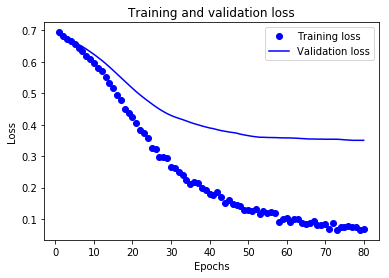

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

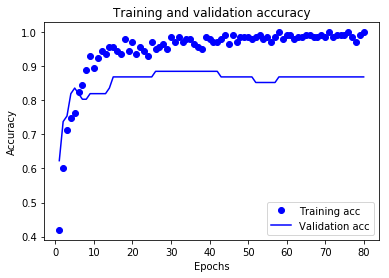

In [17]:
plt.clf() #clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()